## COMP 3400: Data Preparation Techniques Project
## Analysis of popular movies from 1980 to 2019

**Group Members:**
  - Liudmila Strelnikova 201819885
  - David Chicas 201919354
  
 ## Part One: Changes From Iteration One

In this project submission you can find a PDF that addresses all the instrutor's comments about the changes we can make to Iteration 1 to improve it. Those changes have already been addressed in this iteration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import string
import pandas as pd
import jinja2

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import FunctionTransformer

pd.options.mode.chained_assignment = None #chained assignments are not flagged

In [2]:
movies2 = pd.read_csv("movies2.csv")

In [3]:
movies2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7643 entries, 0 to 7642
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7643 non-null   object 
 1   rating    7575 non-null   object 
 2   genre     7643 non-null   object 
 3   year      7643 non-null   int64  
 4   score     7643 non-null   float64
 5   director  7643 non-null   object 
 6   country   7643 non-null   object 
 7   budget    5484 non-null   float64
 8   gross     7466 non-null   float64
 9   company   7632 non-null   object 
 10  runtime   7643 non-null   float64
 11  date      7643 non-null   object 
dtypes: float64(4), int64(1), object(7)
memory usage: 716.7+ KB


In [4]:
movies2.isnull().sum().sort_values(ascending=False)

budget      2159
gross        177
rating        68
company       11
name           0
genre          0
year           0
score          0
director       0
country        0
runtime        0
date           0
dtype: int64

## Part Two: Data Scaling Pre-Assessment


In [5]:
ndf = movies2[['score', 'runtime', 'gross']].dropna()
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7466 entries, 0 to 7642
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   score    7466 non-null   float64
 1   runtime  7466 non-null   float64
 2   gross    7466 non-null   float64
dtypes: float64(3)
memory usage: 233.3 KB


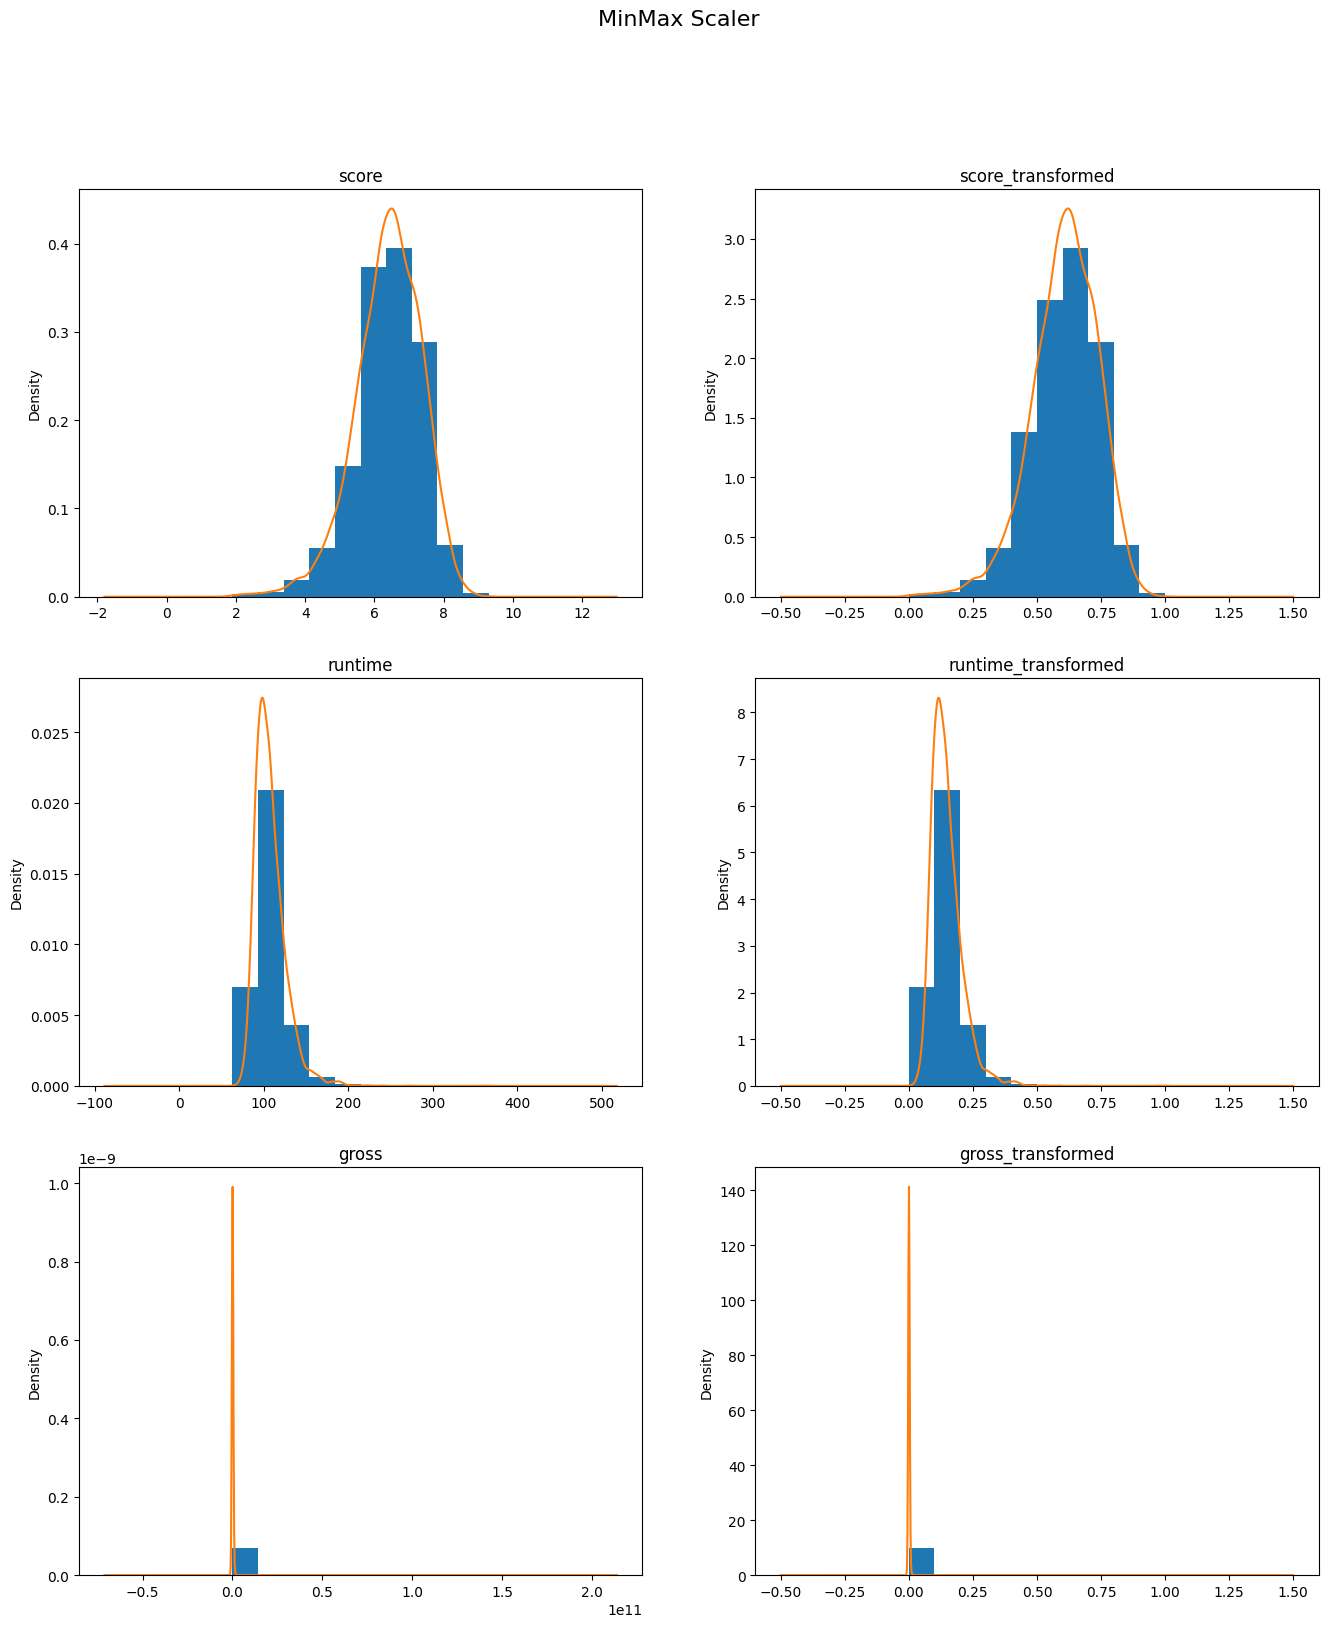

In [6]:
#The function plots graphs in a grid whose dimentions are 2 x (number of attributes).
#A row in the grid consits of two sets of axes. The first set of axes has a histogram of an numeric
#attribute, along with its density function. The second set of axes consists of a histogram
#and density plot of a normalized version of the attribute. The method of normalization is set outsite
#the function.

# @df is the dataframe with numeric attributes 
# @columns is an array with the names of columns in the df
# @df_transformed is a dataframe with normalized attributes of df
# @fit_title is the overall title of all the plots

def density_plots(df, columns, df_transformed, fig_title, constrained_layout=True):
    fig, axs = plt.subplots(len(columns),2,figsize=(16,18))
    fig.suptitle(fig_title, fontsize=16)
    axs = axs.flatten()
    i = 0 
    for c in columns:
        ndf[c].hist(ax=axs[i], density=True) # normalizes the density
        ndf[c].plot.density(ax=axs[i], title=c)
        df_transformed[c].hist(ax=axs[i+1], density=True, stacked=True) # normalizes the density
        df_transformed[c].plot.density(ax=axs[i+1], title=str(c+'_transformed'))
        i+=2

val_cols_names = ['score','runtime','gross']

scaler = MinMaxScaler()
min_max_tdf = scaler.fit_transform(ndf)
min_max_tdf = pd.DataFrame(min_max_tdf, index=ndf.index, columns=ndf.columns)

density_plots(ndf, val_cols_names, min_max_tdf, 'MinMax Scaler')

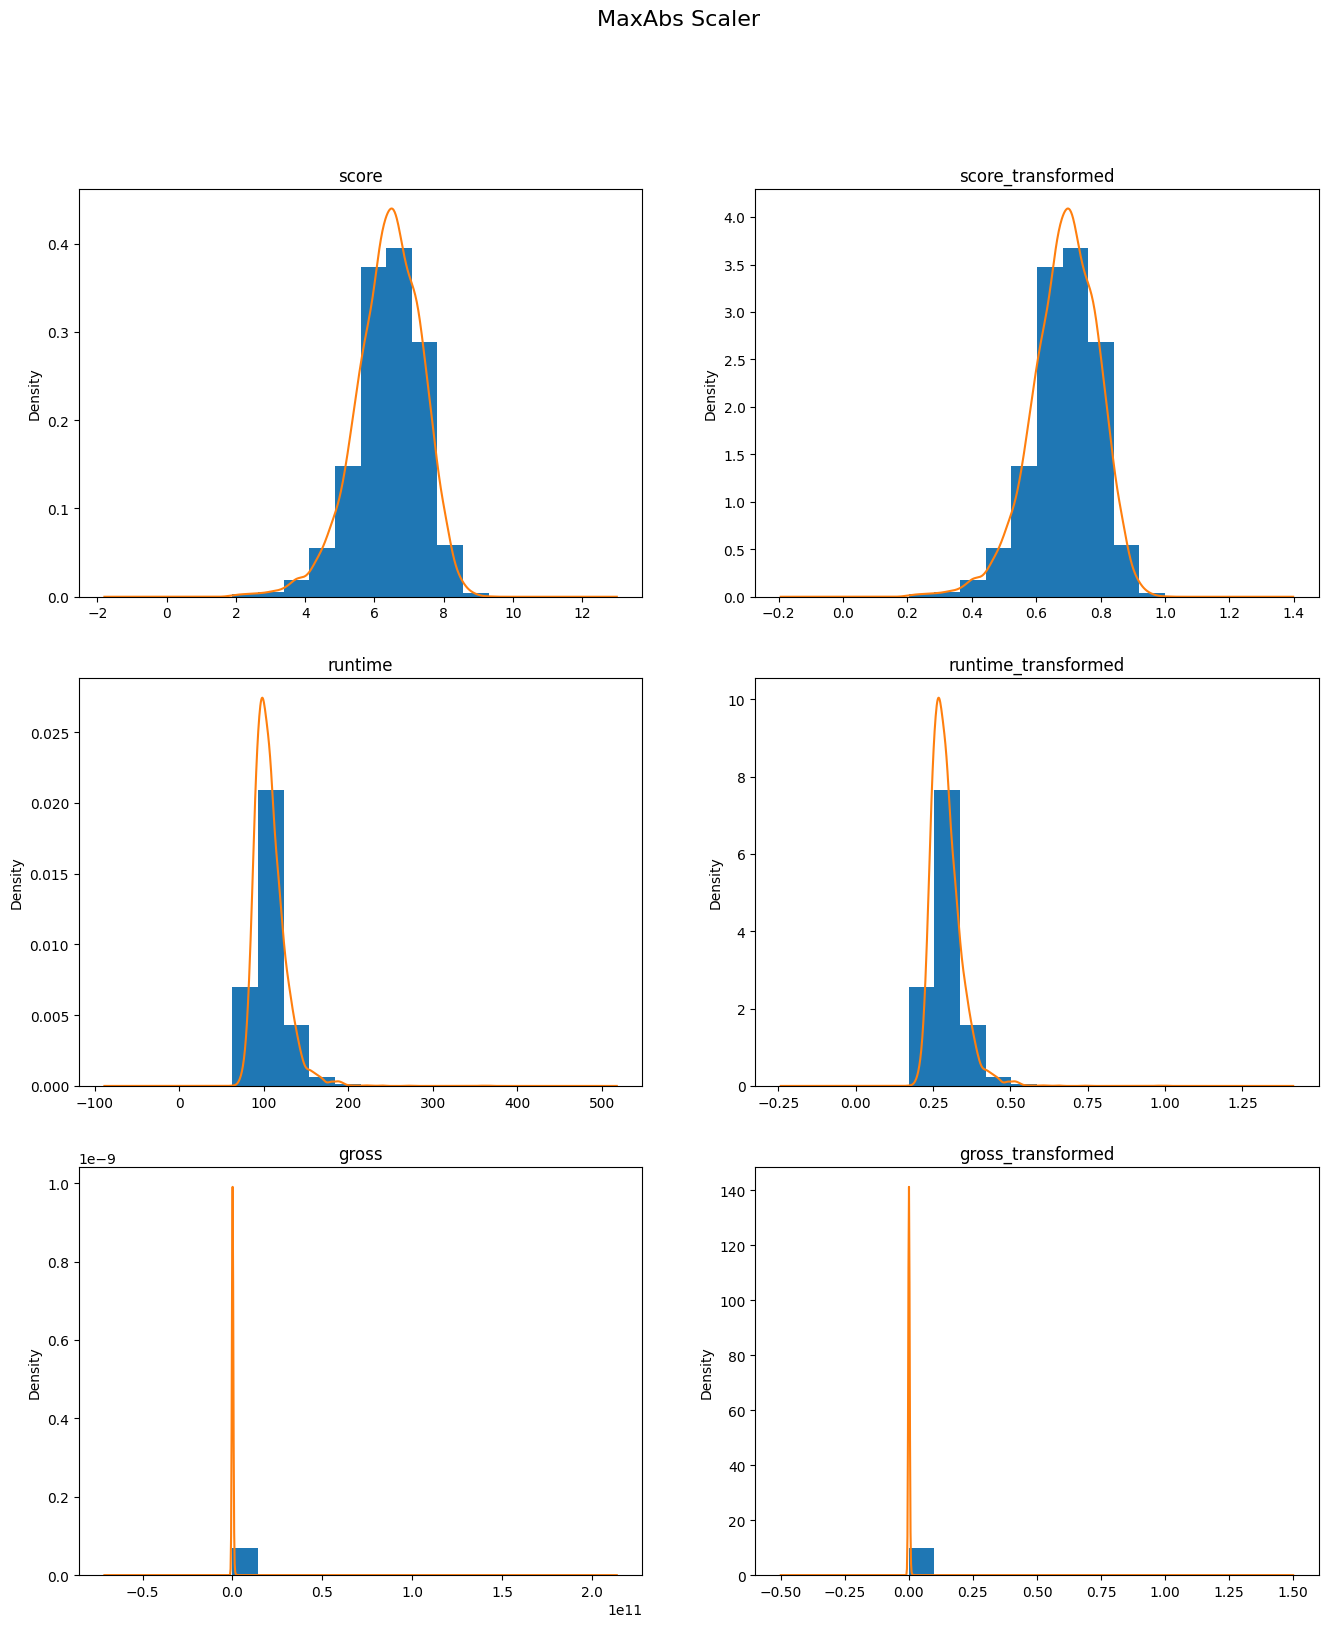

In [7]:
scaler = MaxAbsScaler()
maxabs_tdf = scaler.fit_transform(ndf)
maxabs_tdf = pd.DataFrame(maxabs_tdf, index=ndf.index, columns=ndf.columns)

density_plots(ndf, val_cols_names, maxabs_tdf, 'MaxAbs Scaler')

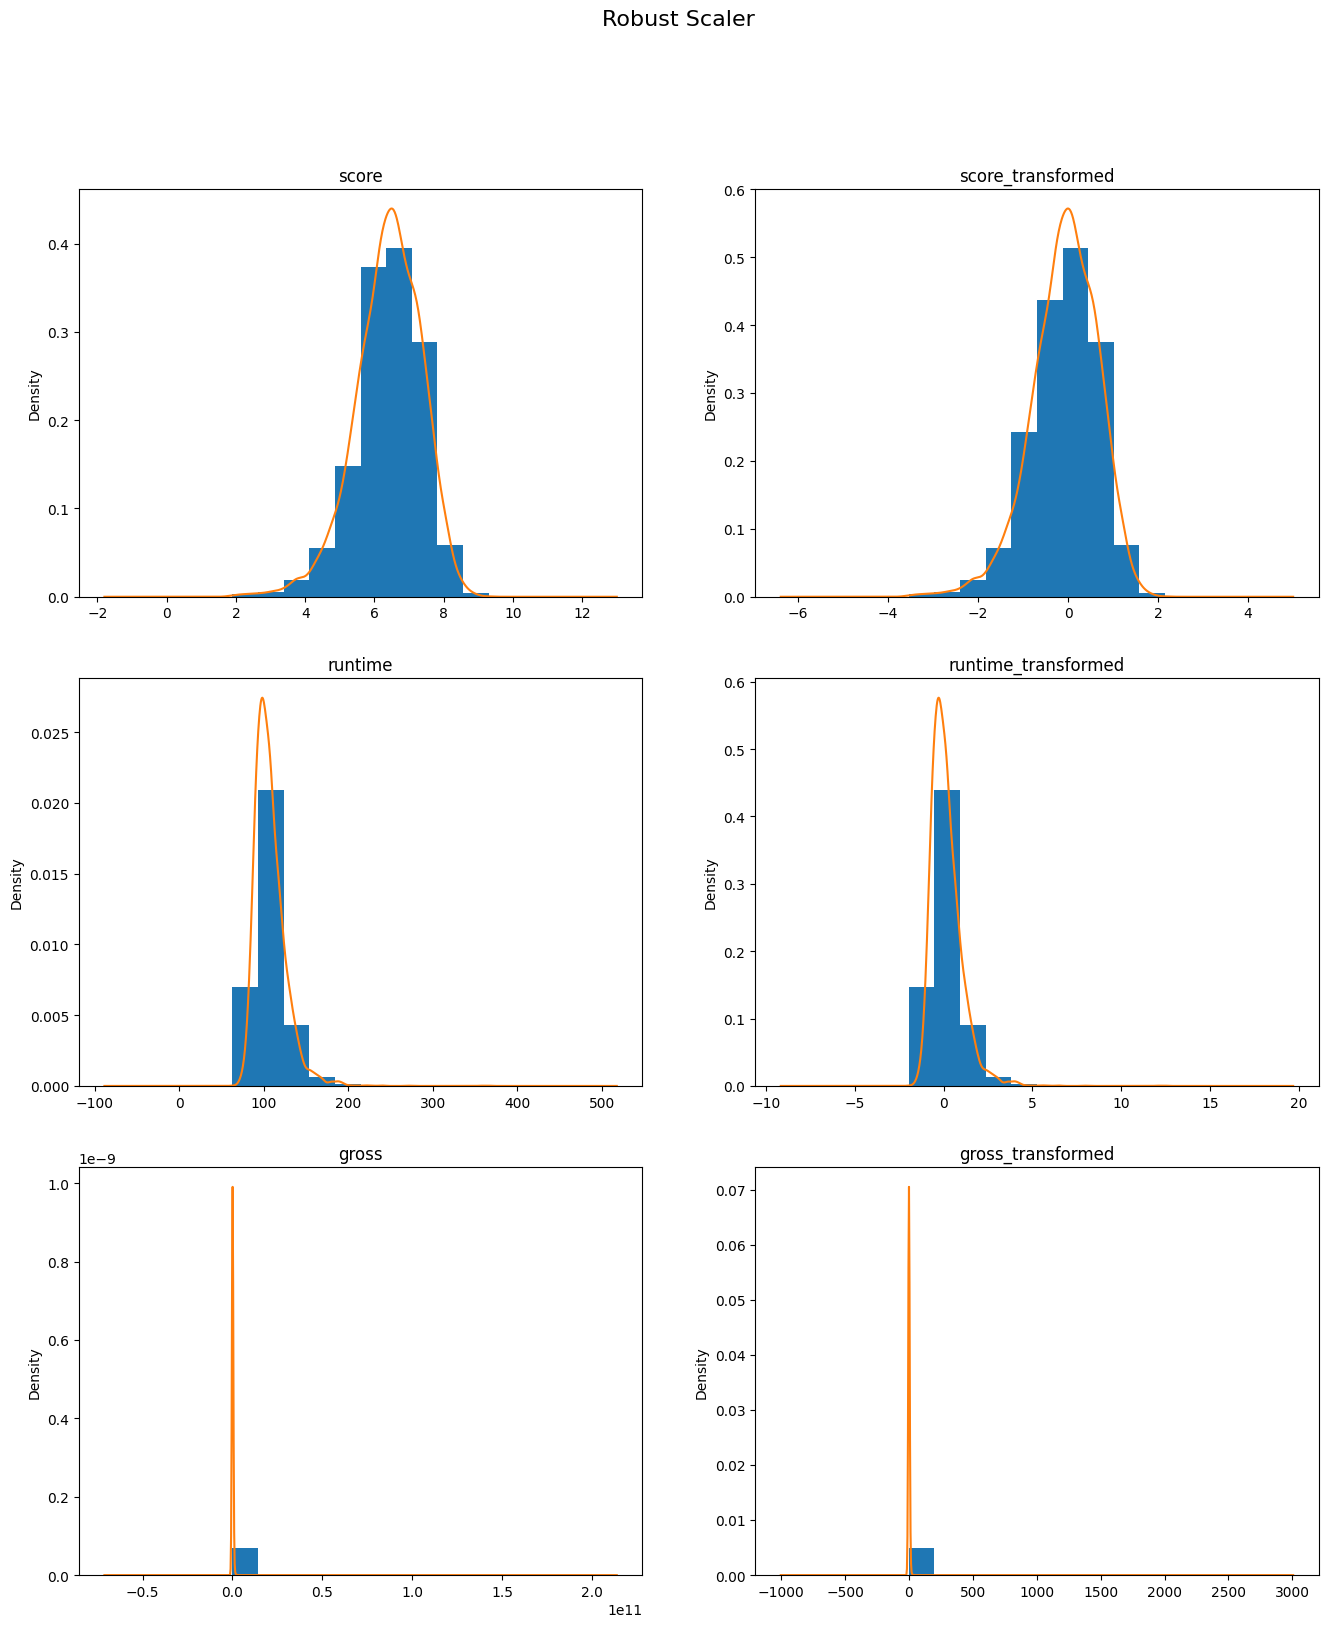

In [8]:
scaler = RobustScaler()
robust_tdf = scaler.fit_transform(ndf)
robust_tdf = pd.DataFrame(robust_tdf, index=ndf.index, columns=ndf.columns)

density_plots(ndf, val_cols_names, robust_tdf, 'Robust Scaler')

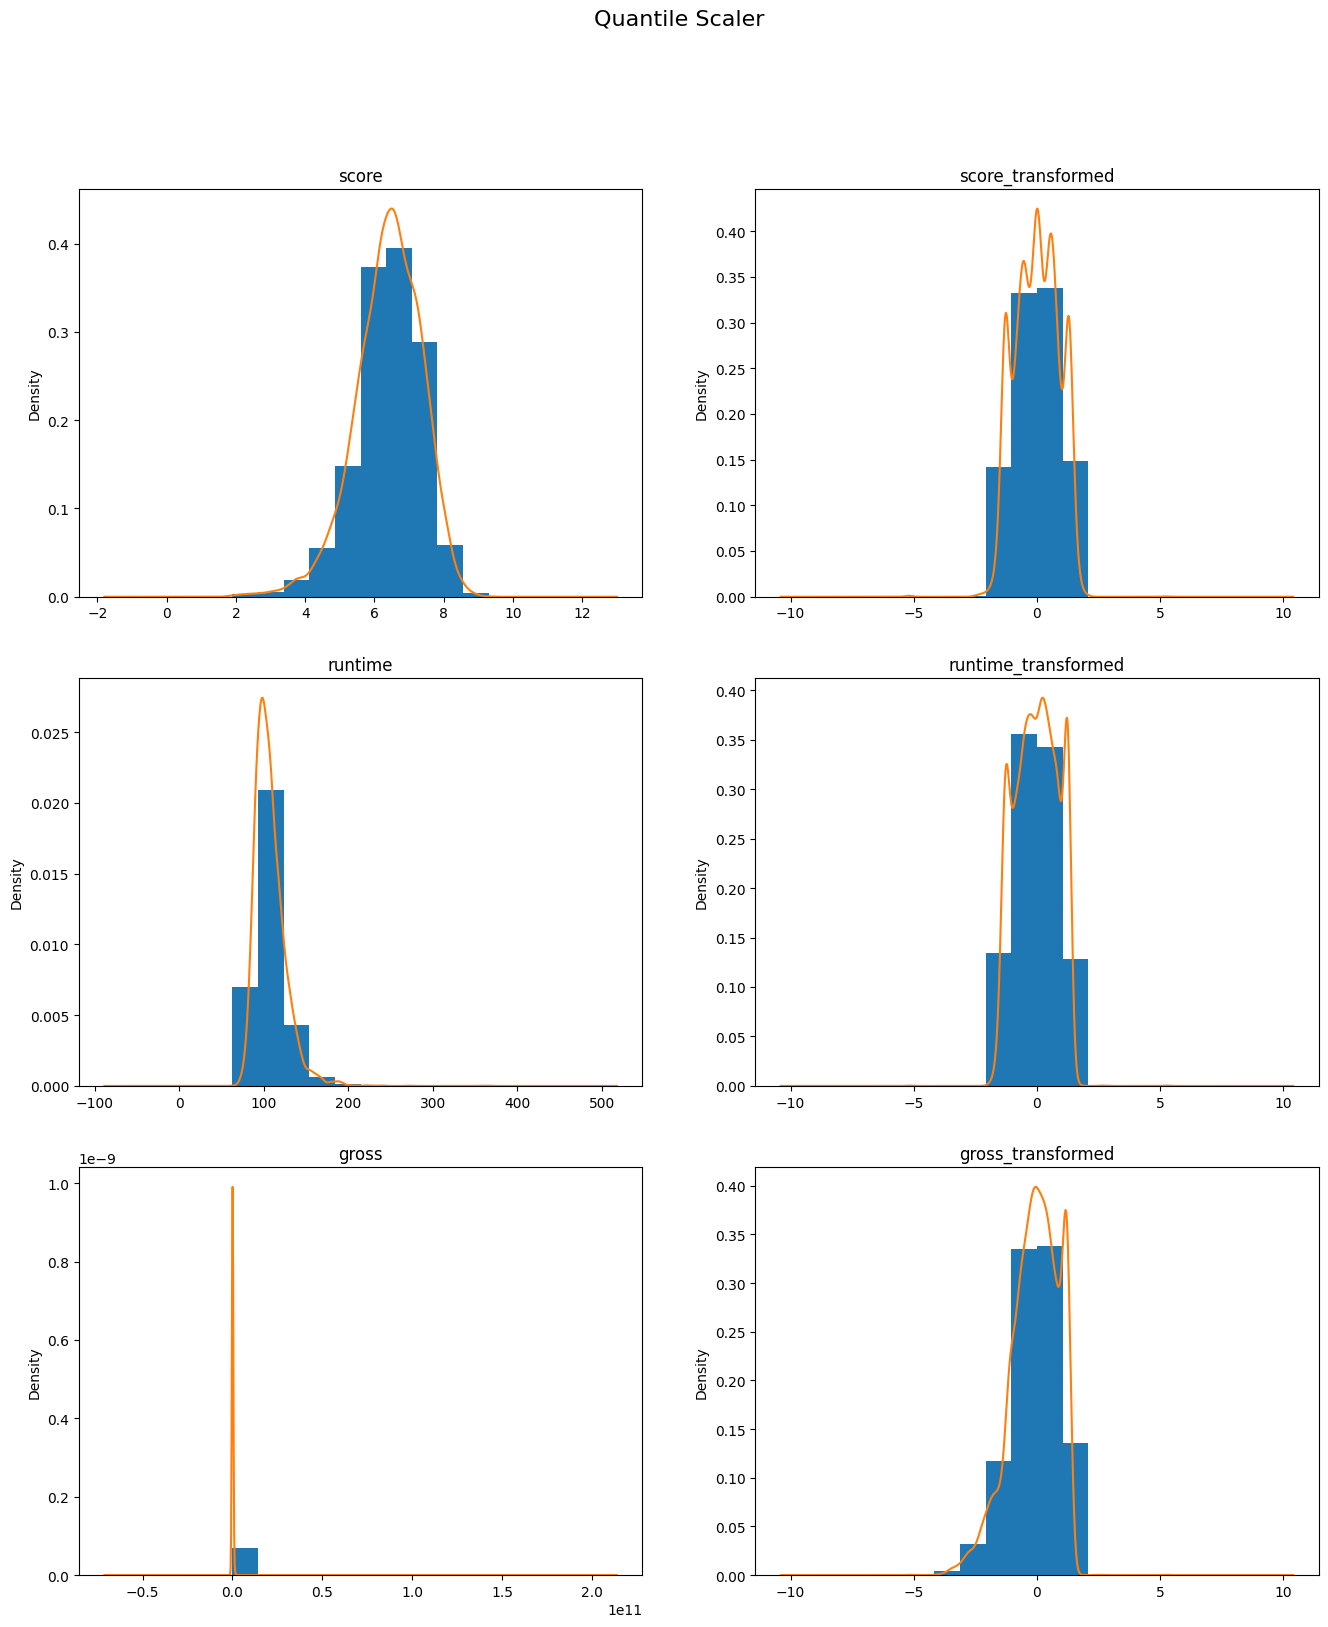

In [9]:
from sklearn.preprocessing import QuantileTransformer

# scaler = QuantileTransformer(n_quantiles=10, random_state=0)
scaler = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')
qtl_tdf = scaler.fit_transform(ndf)
qtl_tdf = pd.DataFrame(qtl_tdf, index=ndf.index, columns=ndf.columns)

density_plots(ndf, val_cols_names, qtl_tdf, 'Quantile Scaler')

## Standardization

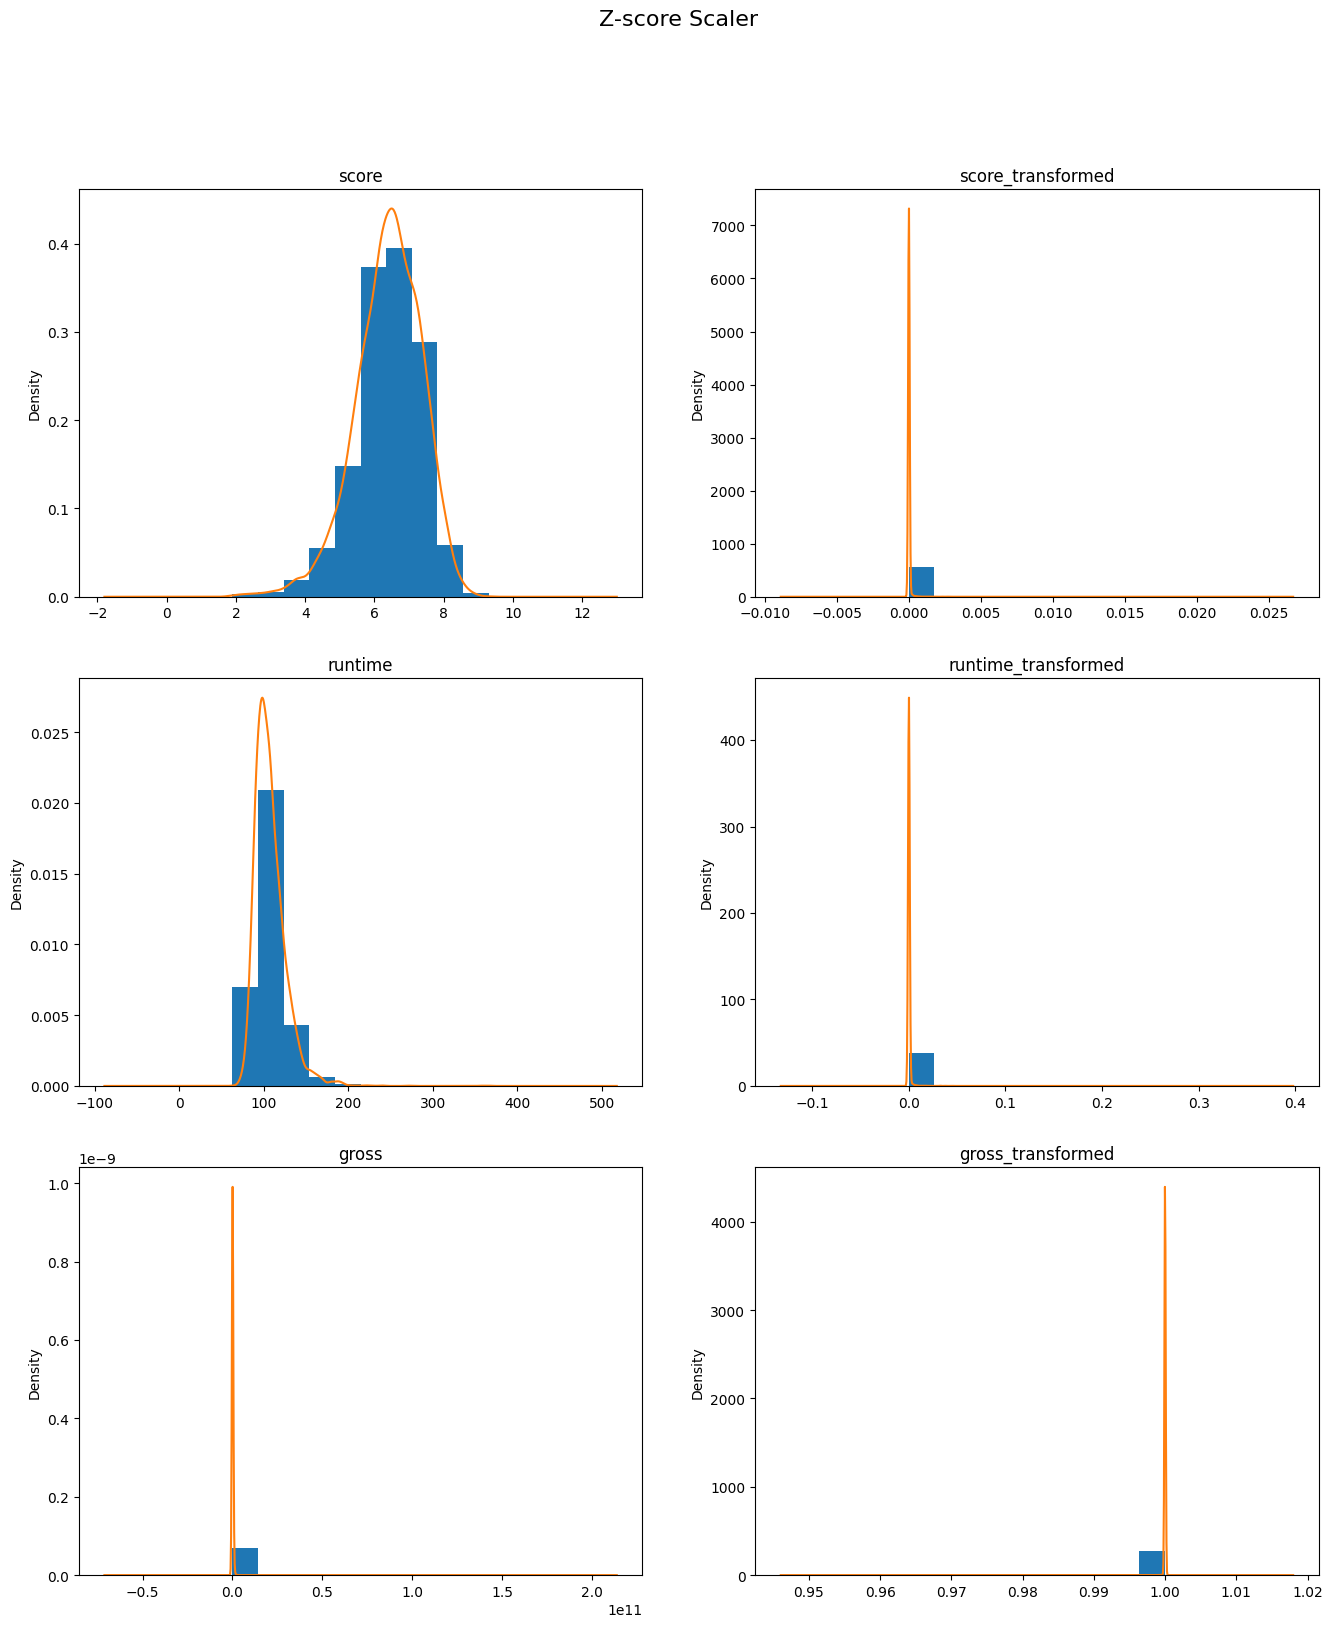

In [10]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
zscore_tdf = scaler.fit_transform(ndf)
zscore_tdf = pd.DataFrame(zscore_tdf, index=ndf.index, columns=ndf.columns)

density_plots(ndf, val_cols_names, zscore_tdf, 'Z-score Scaler')

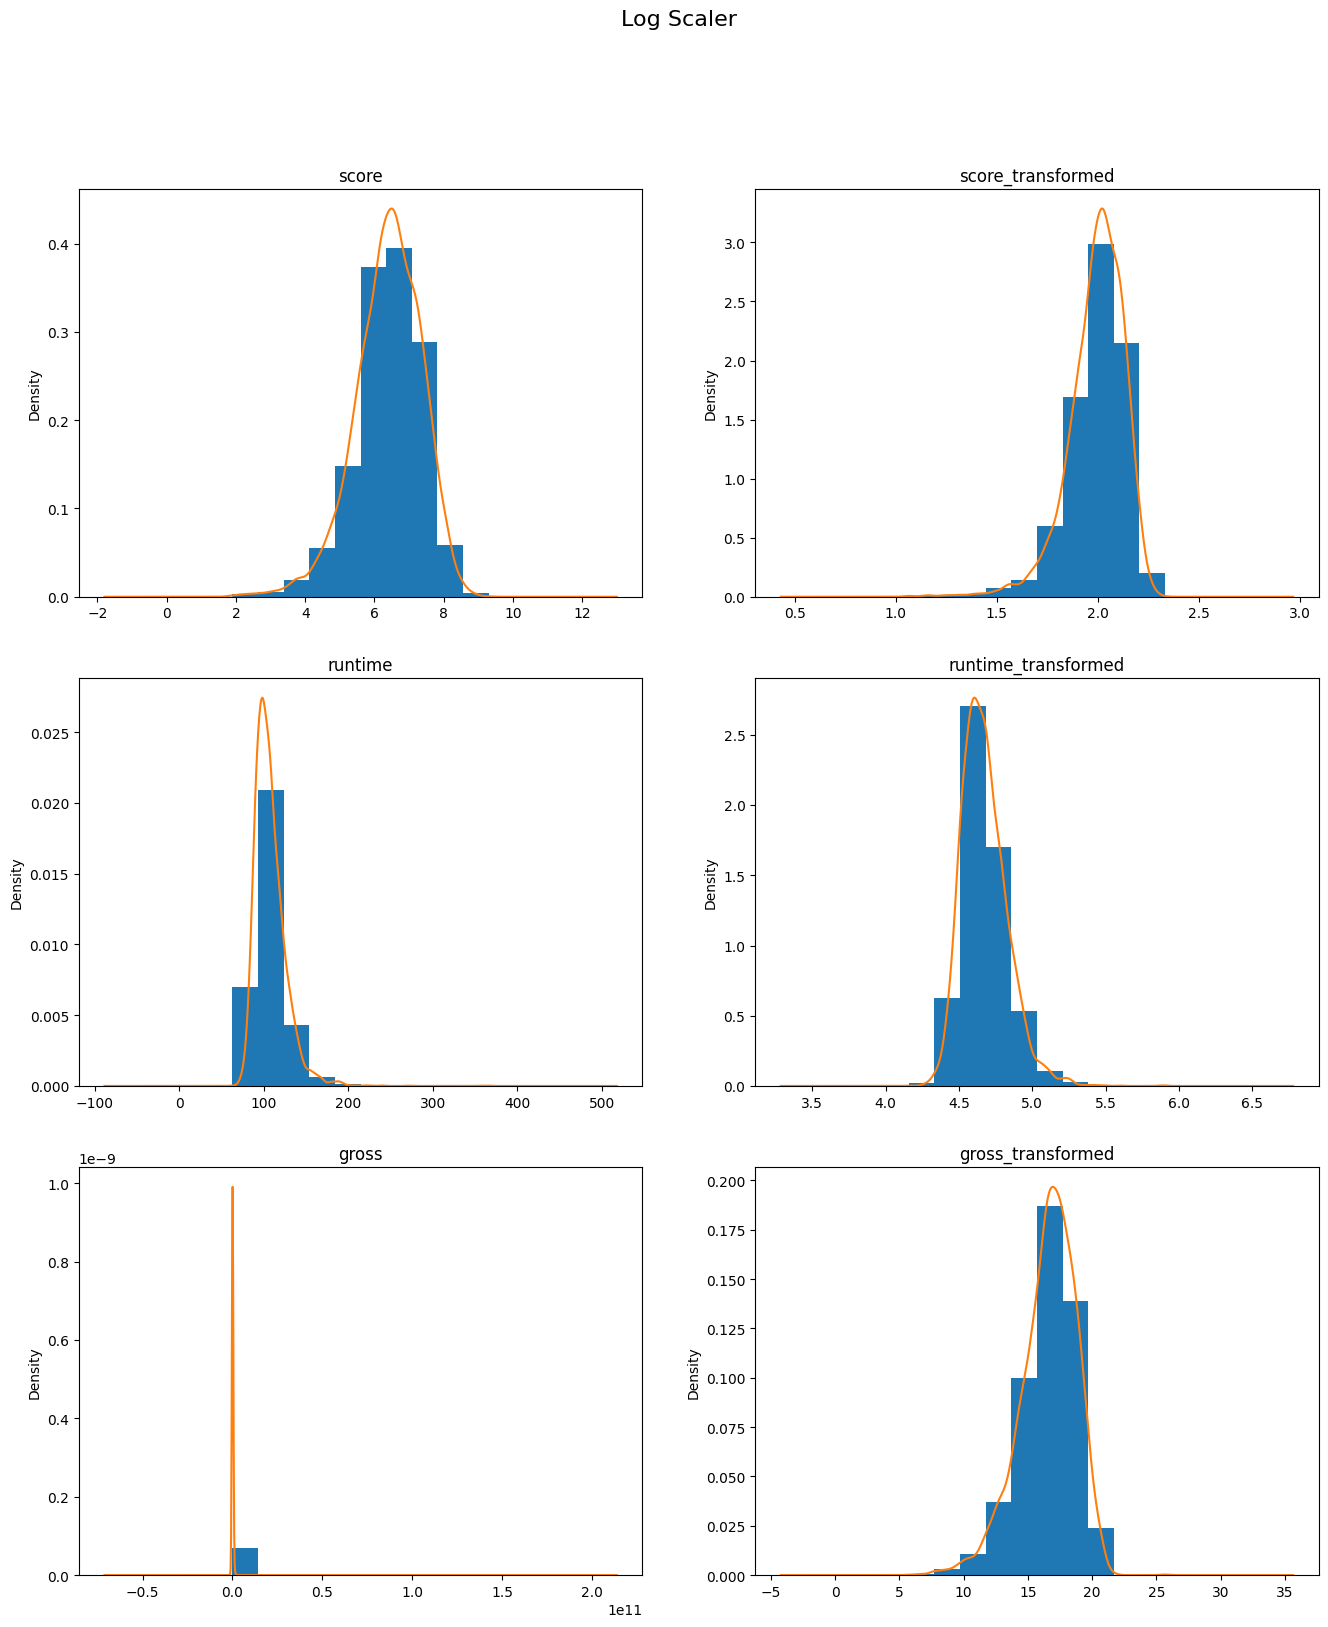

In [11]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

scaler = FunctionTransformer(np.log1p)
log_tdf = scaler.fit_transform(ndf)
log_tdf = pd.DataFrame(log_tdf, index=ndf.index, columns=ndf.columns)

density_plots(ndf, val_cols_names, log_tdf, 'Log Scaler')

We can plot all the normalization and standardization plots togethe

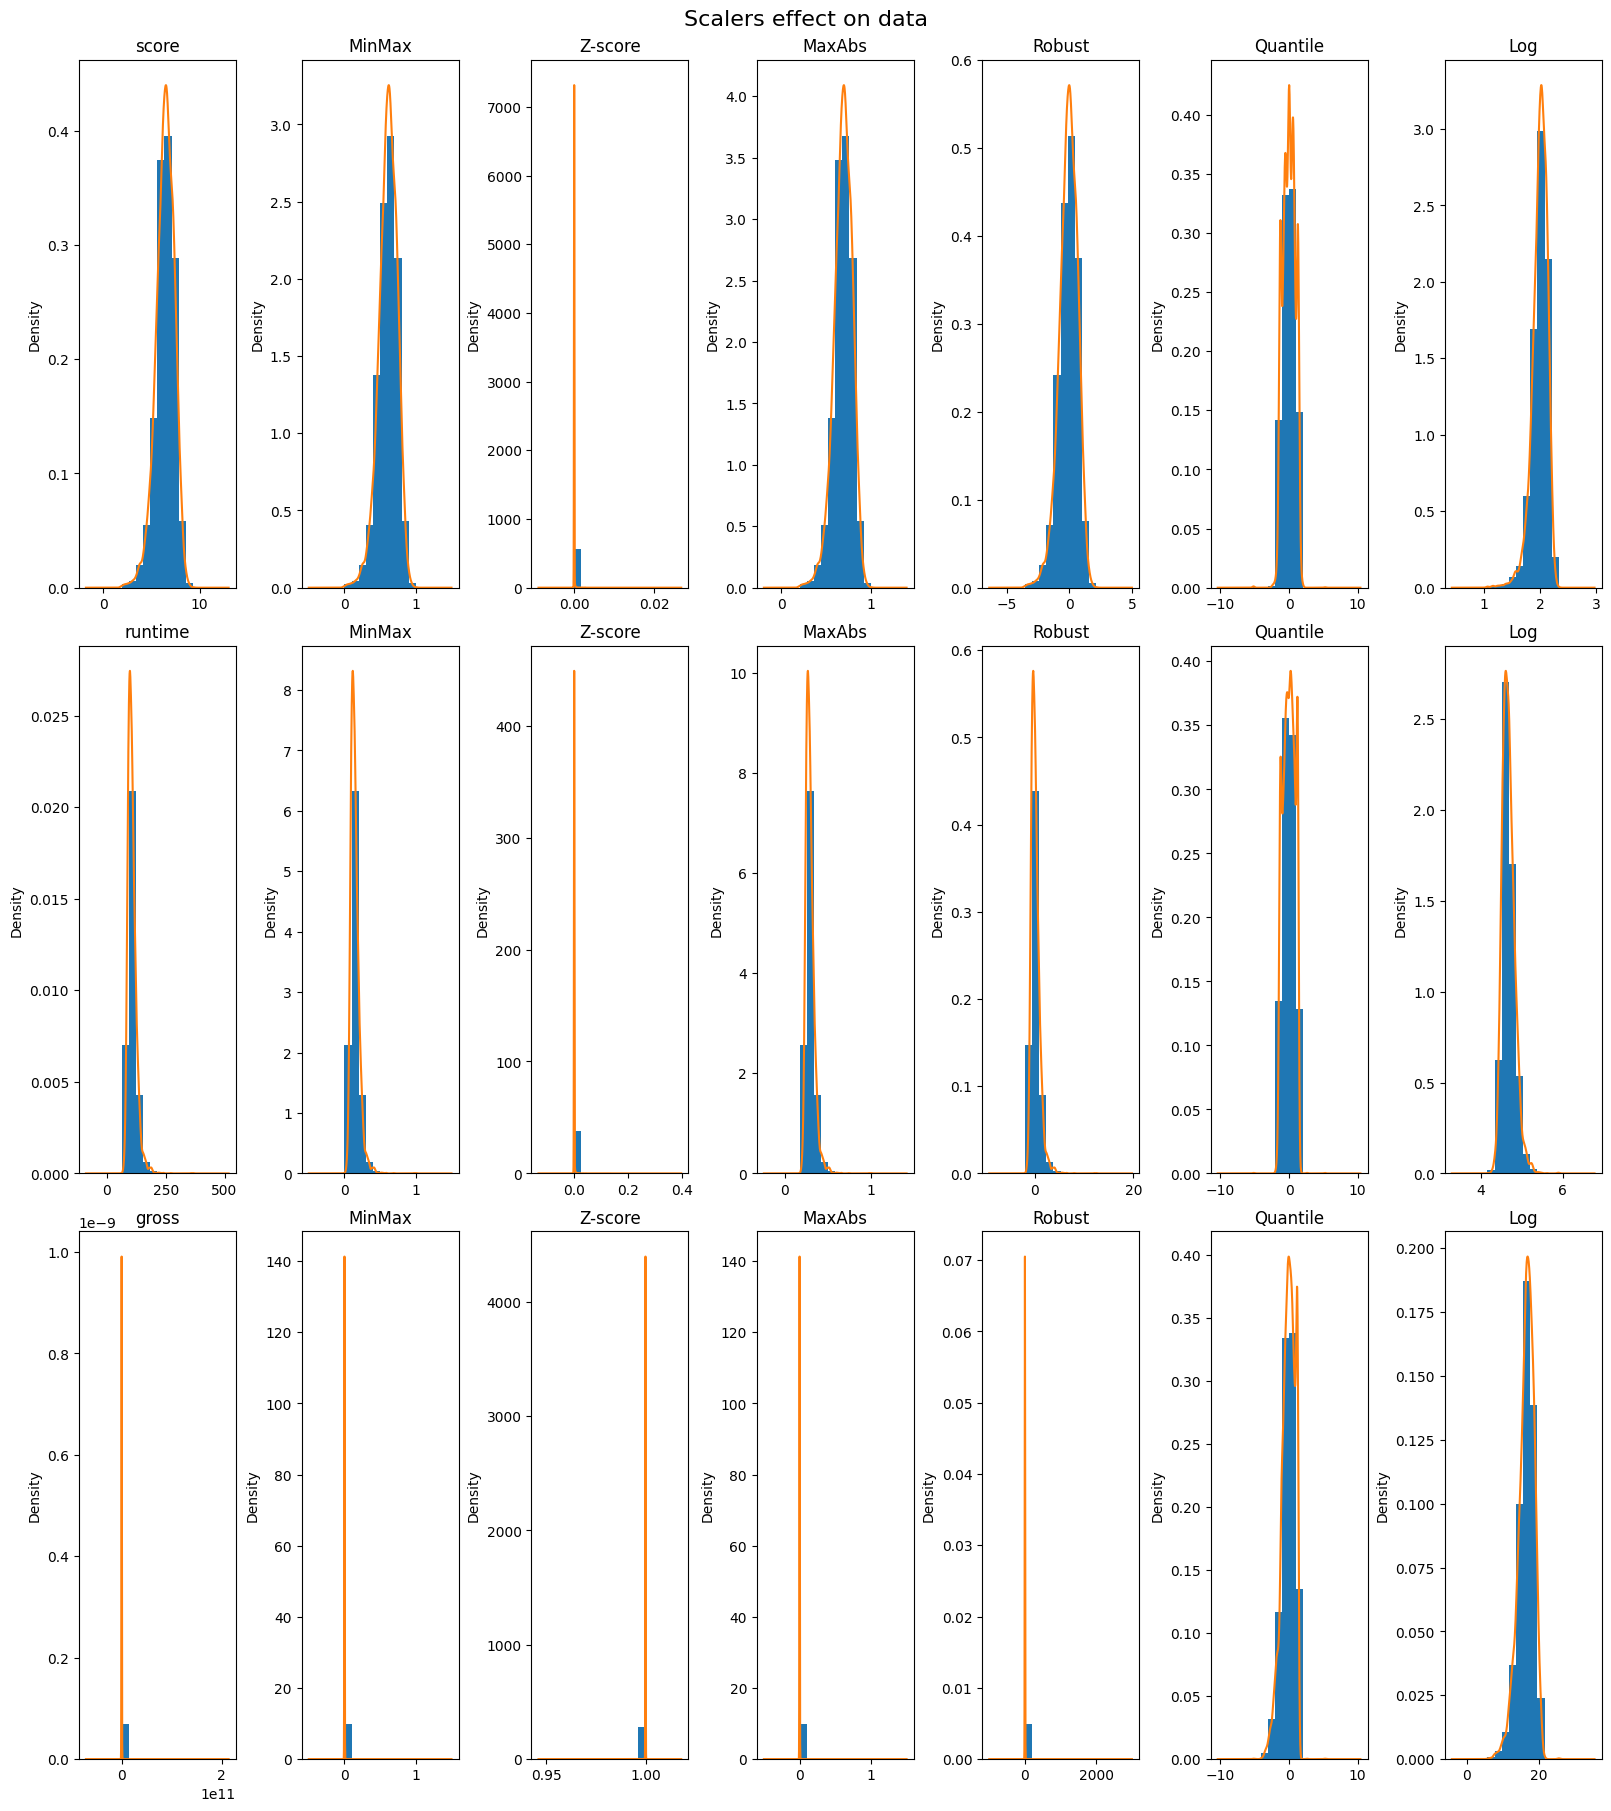

In [12]:
def plot_histograms_density_for_scalers(df, columns, fig_title, scalers, scaler_names):
    fig, axs = plt.subplots(len(columns),len(scalers)+1,figsize=(16,18),constrained_layout=True)
    fig.suptitle(fig_title, fontsize=16)
    axs = axs.flatten()
    i = 0 
    for c in columns:
        ndf[c].hist(ax=axs[i], density=True) # normalizes the density
        ndf[c].plot.density(ax=axs[i], title=c)
        i+=1
        for j in range(len(scalers)):
            df_transformed = scalers[j].fit_transform(df)
            df_transformed = pd.DataFrame(df_transformed, index=df.index, columns=df.columns)
            df_transformed[c].hist(ax=axs[i], density=True, stacked=True) # normalizes the density
            df_transformed[c].plot.density(ax=axs[i], title=scaler_names[j])
            i+=1
            

val_cols_names = ['score','runtime','gross']
scaler_names = ['MinMax', 'Z-score', 'MaxAbs', 'Robust', 'Quantile', 'Log']
arr_scalers = [MinMaxScaler(), Normalizer(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal'),FunctionTransformer(np.log1p)]
plot_histograms_density_for_scalers(ndf, val_cols_names, 'Scalers effect on data', arr_scalers, scaler_names)

From the charts above, it is clear that the only normalization technicque that worked on the gross attribute is quantile transform scaler (QTS). QTS maps the variable's probability distribution to another probablility distribution, and performs well with unimodal data, which includes the distribution of gross values.

Score has a normal distribution with minimal skewness, so min-max scaler works well for this attribute.

Runtime is a bit more skewed than score, so robust scaler is the best choice for this attribute's normalization. Robust scaler removes the median, and scales data according to 

## Encodings

Unsupervised learning models only use continuous attributes, therefore attributes rating, genre, and  country should be encoded. 
The attributes do not possess much hierarchy, and can be encoded with a simple label encoder.

Note: I have to make a translation for encodings. 

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 
df_le = movies2.copy()

df_le['rating_en'] = le.fit_transform(df_le['rating'])
df_le['genre_en'] = le.fit_transform(df_le['genre'])
df_le['country_en'] = le.fit_transform(df_le['country'])

to_drop = ['rating', 'genre', 'country']
df_le = df_le.drop(to_drop,axis=1)

df_le = df_le.rename(columns = {"rating_en":"rating", "genre_en":"genre", "country_en":"country"})
movies2 = df_le
movies2.head(10)

,name,year,score,director,budget,gross,company,runtime,date,rating,genre,country
0,The Shining,1980,8.4,Stanley Kubrick,19000000.0,46998772.0,Warner Bros.,146.0,1980-06-13,5,6,54
1,The Blue Lagoon,1980,5.8,Randal Kleiser,4500000.0,58853106.0,Columbia Pictures,104.0,1980-07-02,5,1,55
2,Star Wars: Episode V - The Empire Strikes Back,1980,8.7,Irvin Kershner,18000000.0,538375067.0,Lucasfilm,124.0,1980-06-20,3,0,55
3,Airplane!,1980,7.7,Jim Abrahams,3500000.0,83453539.0,Paramount Pictures,88.0,1980-07-02,3,4,55
4,Caddyshack,1980,7.3,Harold Ramis,6000000.0,39846344.0,Orion Pictures,98.0,1980-07-25,5,4,55
5,Friday the 13th,1980,6.4,Sean S. Cunningham,550000.0,39754601.0,Paramount Pictures,95.0,1980-05-09,5,10,55
6,The Blues Brothers,1980,7.9,John Landis,27000000.0,115229890.0,Universal Pictures,133.0,1980-06-20,5,0,55
7,Raging Bull,1980,8.2,Martin Scorsese,18000000.0,23402427.0,Chartoff-Winkler Productions,129.0,1980-12-19,5,3,55
8,Superman II,1980,6.8,Richard Lester,54000000.0,108185706.0,Dovemead Films,127.0,1981-06-19,3,0,55
9,The Long Riders,1980,7.0,Walter Hill,10000000.0,15795189.0,United Artists,100.0,1980-05-16,5,3,55


## Training a model 

The only values that can be used while trainng a model are encoded or numeric values, so the ones that do not fit this description should be dropped.

In [14]:
to_drop = ['name', 'director', 'company', 'date']
m2 = movies2.drop(to_drop, axis=1)

In [15]:
m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7643 entries, 0 to 7642
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     7643 non-null   int64  
 1   score    7643 non-null   float64
 2   budget   5484 non-null   float64
 3   gross    7466 non-null   float64
 4   runtime  7643 non-null   float64
 5   rating   7643 non-null   int64  
 6   genre    7643 non-null   int64  
 7   country  7643 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 477.8 KB


We can start with predicting the values for **gross** attribute, as it has about 150 values missing. 

In [16]:
#Saving rows to fix in a separate dataframe
rows_to_fix_gross = m2[m2['gross'].isna()].copy()

In [17]:
rows_to_fix_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 27 to 7641
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     177 non-null    int64  
 1   score    177 non-null    float64
 2   budget   54 non-null     float64
 3   gross    0 non-null      float64
 4   runtime  177 non-null    float64
 5   rating   177 non-null    int64  
 6   genre    177 non-null    int64  
 7   country  177 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 12.4 KB


In [18]:
#Saving the rows with no missing values into a separate dataframe
#No missing values should be present when training a model
m2_clean = m2.dropna()

In [19]:
m2_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5430 entries, 0 to 7616
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     5430 non-null   int64  
 1   score    5430 non-null   float64
 2   budget   5430 non-null   float64
 3   gross    5430 non-null   float64
 4   runtime  5430 non-null   float64
 5   rating   5430 non-null   int64  
 6   genre    5430 non-null   int64  
 7   country  5430 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 381.8 KB


Two models will be used to train data: Linear Classification and KNN. The metric used for cross-validation will be F-score.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

The scalers that we chose previously were Quantile and Log. We will also try to use Z-score and Robust scaler to see how they affect the predicitons. 

In [24]:
scaler_names = ['Z-score', 'Robust', 'Log', 'Quantile']
arr_scalers = [Normalizer(), RobustScaler(), FunctionTransformer(np.log1p), QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')]
results = {}

First, we are going to expore KNN model. Number of neighbours here is chose as approximately square root of the number of variables. 

In [31]:
model = KNeighborsClassifier(n_neighbors=73)

In [39]:
for i in range (len(arr_scalers)):
    # X is all variables except gross
    X = m2_clean.drop(['gross'], axis=1).to_numpy()

    # Scaling X    
    X_t = arr_scalers[i].fit_transform(X)

    # y is gross that we want to forecast
    y = m2_clean['gross'].to_numpy()
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X_t, y, scoring='r2', cv=cv, n_jobs=-1)
    results[scaler_names[i]] = scores

In [40]:
# The model with the raw data just to put the models side-by-side
X = m2_clean.drop(['gross'], axis=1).to_numpy()
X_t = arr_scalers[i].fit_transform(X)
y = m2_clean['gross'].to_numpy()
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(model, X_t, y, scoring='r2', cv=cv, n_jobs=-1)
results['Raw data'] = scores

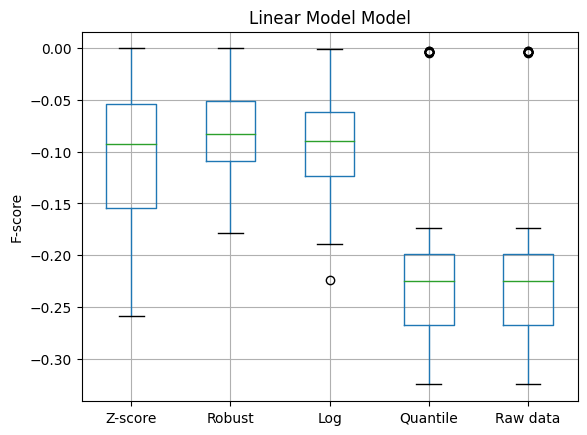

In [41]:
df_res = pd.DataFrame(results)
boxplot = df_res.boxplot() 
boxplot.set_ylabel('F-score')
plt.title('Linear Model Model')
plt.show()